# Submission

- ensembel CE models (last fc layer)   
15 models (street, top, sentinel)
new 15 models


In [1]:
#--
import sys
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace")
import map_dataset
import map_train
from models import *

sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_models
import RS_utils
#--- torch
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
#--- loss functions
from utils.losses import LabelSmoothCrossEntropy, CrossEntropyLoss
from torch.cuda.amp import GradScaler, autocast
#---
from lightning.fabric import Fabric
from lightning.fabric.loggers import CSVLogger, TensorBoardLogger
from torchmetrics.classification import Accuracy
import pandas as pd 
import os 
from sklearn.model_selection import train_test_split
import argparse
import yaml 
import timm
import numpy as np 
import time
import wandb
import random
import matplotlib.pyplot as plt
from rich.console import Console
from tqdm import tqdm 

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations
/mnt/hdd/eric/.conda/envs/mapv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#--- all infos
inference_dict ={
    'models':[],
    'folds' :[],
    'data' :[],
    'cfgs':[],
    'predictions':[],
    'labels':[]
}

#--- argparser
cfgs_names = ['finetune_28.yaml', 'finetune_27.yaml','finetune_26.yaml']
for cfg_name in cfgs_names:    
    parser = argparse.ArgumentParser()
    parser.add_argument('--cfg', type=str, default=os.path.join('/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/configs', cfg_name))
    args = parser.parse_args(args=[])
    cfg = argparse.Namespace(**yaml.load(open(args.cfg), Loader=yaml.SafeLoader))
    
    for fold_ in range(cfg.N_SPLIT):        
        inference_dict['cfgs'].append(cfg)
        inference_dict['folds'].append(fold_)
        inference_dict['data'].append(cfg.DATA_TYPE)
        print("Model run version : ", cfg.RUN_VERSION)
        print("Model run fold : ", fold_)
        print("Data type : ", cfg.DATA_TYPE)


Model run version :  43
Model run fold :  0
Data type :  streetview
Model run version :  43
Model run fold :  1
Data type :  streetview
Model run version :  43
Model run fold :  2
Data type :  streetview
Model run version :  43
Model run fold :  3
Data type :  streetview
Model run version :  43
Model run fold :  4
Data type :  streetview
Model run version :  42
Model run fold :  0
Data type :  topview
Model run version :  42
Model run fold :  1
Data type :  topview
Model run version :  42
Model run fold :  2
Data type :  topview
Model run version :  42
Model run fold :  3
Data type :  topview
Model run version :  42
Model run fold :  4
Data type :  topview
Model run version :  41
Model run fold :  0
Data type :  sentinel2
Model run version :  41
Model run fold :  1
Data type :  sentinel2
Model run version :  41
Model run fold :  2
Data type :  sentinel2
Model run version :  41
Model run fold :  3
Data type :  sentinel2
Model run version :  41
Model run fold :  4
Data type :  sentinel2


In [3]:
#--- Data 
input_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Map_Your_City/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"
train_df = pd.read_csv(input_path + "train/train-set.csv")
test_df = pd.read_csv(input_path + "test/test-set.csv") 

#--- data split 
names_data = sorted( os.listdir(train_path) )

names_label = []
for ID in names_data:
    y = int(open(train_path + ID + '/label.txt', "r").read())
    names_label.append(y)


In [4]:
for cfg in inference_dict['cfgs']:   
    model = timm.create_model(
    cfg.MODEL,
    pretrained=True,
    num_classes=cfg.CLASSES_NUM )

    #--- data config and transform
    data_config = timm.data.resolve_model_data_config(model)
    data_transform = timm.data.create_transform(**data_config, is_training=False)

    inference_dict['models'].append(model)
    print("#------------------------------------")
    print(" Model Name : ",cfg.MODEL)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva_large_patch14_336.in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva_large_patch14_336.in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva_large_patch14_336.in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva_large_patch14_336.in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva_large_patch14_336.in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva_large_patch14_336.in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva_large_patch14_336.in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva_large_patch14_336.in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva_large_patch14_336.in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva_large_patch14_336.in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva_large_patch14_336.in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva_large_patch14_336.in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva_large_patch14_336.in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva_large_patch14_336.in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva_large_patch14_336.in22k_ft_in22k_in1k


In [5]:

#--- all the candidates for ensembles based on validation score 

saved_root = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output"
check_points = sorted(os.listdir(saved_root))
target_runs = list(set([ cfg.RUN_VERSION for cfg in inference_dict['cfgs']]))

In [6]:

def find_best_model(target_run_n):
    
    target_runs_0 = [i for i in check_points if str(i.split("_")[0]) == str(target_run_n) ]
    
    best_model_runs = []
    for fold_n in range(0,cfg.N_SPLIT):
        fold_s = [ i for i in target_runs_0 if str(i.split("_")[-5]) == str(fold_n) ]
        #print(fold_s)
        best_model = ""
        best_score = 0
        for fq in fold_s:
            score =  float(fq.split("_")[-3])
            if score > best_score:
                score = best_score
                best_model = fq
        best_model_runs.append(best_model)
    return best_model_runs  

In [7]:
#--- find all 
global_best_models = []
for tg in target_runs:
    fold_best_models = find_best_model(tg)
    global_best_models.extend(fold_best_models)


# Define the categories in the desired order
categories = ['streetview', 'topview', 'sentinel2']

# Create a dictionary to hold lists of file paths for each category
categorized_files = {category: [] for category in categories}

# Categorize the file paths
for path in global_best_models:
    for category in categories:
        if category in path:
            categorized_files[category].append(path)
            break

# Reorder the file paths based on the desired order
ordered_file_paths = []
for category in categories:
    ordered_file_paths.extend(categorized_files[category])

# Print the ordered file paths
for path in ordered_file_paths:
    print(path)

# load weights
ckpt_paths =[ os.path.join(saved_root,i) for i in ordered_file_paths]
for i,model in enumerate(inference_dict['models']):
    model.load_state_dict(torch.load(ckpt_paths[i])['model'] )

43_eva_large_patch14_336.in22k_ft_in22k_in1k_streetview_CE_fold_0_recall_0.7099_epoch_7.pth
43_eva_large_patch14_336.in22k_ft_in22k_in1k_streetview_CE_fold_1_recall_0.7054_epoch_7.pth
43_eva_large_patch14_336.in22k_ft_in22k_in1k_streetview_CE_fold_2_recall_0.7028_epoch_7.pth
43_eva_large_patch14_336.in22k_ft_in22k_in1k_streetview_CE_fold_3_recall_0.6939_epoch_7.pth
43_eva_large_patch14_336.in22k_ft_in22k_in1k_streetview_CE_fold_4_recall_0.7051_epoch_7.pth
42_eva_large_patch14_336.in22k_ft_in22k_in1k_topview_CE_fold_0_recall_0.7004_epoch_6.pth
42_eva_large_patch14_336.in22k_ft_in22k_in1k_topview_CE_fold_1_recall_0.7015_epoch_7.pth
42_eva_large_patch14_336.in22k_ft_in22k_in1k_topview_CE_fold_2_recall_0.6997_epoch_6.pth
42_eva_large_patch14_336.in22k_ft_in22k_in1k_topview_CE_fold_3_recall_0.6809_epoch_7.pth
42_eva_large_patch14_336.in22k_ft_in22k_in1k_topview_CE_fold_4_recall_0.6937_epoch_2.pth
41_eva_large_patch14_336.in22k_ft_in22k_in1k_sentinel2_CE_fold_0_recall_0.6476_epoch_7.pth
41_e

In [8]:
valid_set = map_dataset.Map_Dataset_v14(names_data,train_path,max_size=data_config['input_size'][1],cfg=cfg,split="valid")  

idx :  584


5 < Label > 
5 < Model Prediction > 
tensor([[0.0087, 0.0211, 0.0123, 0.0058, 0.0018, 0.8982, 0.0522]],
       device='cuda:3')


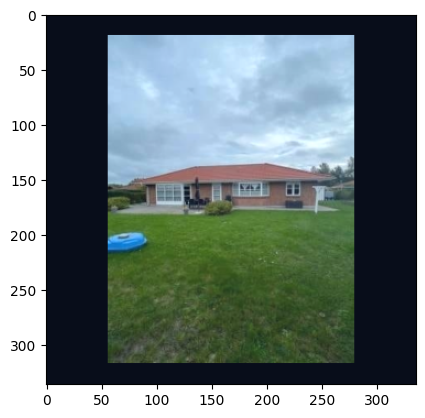

In [9]:
#--- inference
device = "cuda:3"
cfg.DEVICE = device
#--- 

idx_ = random.randint(0,999)
print("idx : ", idx_)

dataset = valid_set

street_view = dataset.__getitem__(idx_)[0]
top_view = dataset.__getitem__(idx_)[1]
sentinel2 = dataset.__getitem__(idx_)[2]
img_torch_1 = street_view 
img_torch_2 = top_view
img_torch_3 = sentinel2
loss_type = "CE"

def infer_model_(img_torch_1,model,loss_type):
    with torch.no_grad():
        img_torch_1 = img_torch_1.to(device)
        model = model.to(device)
        model = model.eval()
        img_torch_1 = img_torch_1.unsqueeze(0)
        preds = model(img_torch_1)

        if loss_type == "CE":
            preds_ = preds.softmax(-1).argmax(-1)
        elif loss_type == "MSE" or loss_type == "MAE":
            preds_ = preds
        print(dataset.__getitem__(idx_)[-1], "< Label > ")
        print(preds_.item(), f"< Model Prediction > ")
        #print(preds)
        print(preds.softmax(-1))
        
        img_torch_1 = img_torch_1.squeeze(0)
        img1 = img_torch_1.clone() 
        
        # denormal
        img1 = ((img1) * 0.22) + 0.5
        # [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        #---      
        img1 = img1.permute(1,2,0).cpu()
        img1 = np.asarray(img1)
        
        #---
        # fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,10))
        # ax[0].imshow(img1)
        # ax[1].imshow(img2)
        # ax[2].imshow(img3)
        
        plt.figure()
        plt.imshow(img1)


#----
infer_model_(img_torch_1, inference_dict['models'][0],loss_type)

5 < Label > 
5 < Model Prediction > 
tensor([[0.0217, 0.0226, 0.0342, 0.0140, 0.0121, 0.8457, 0.0496]],
       device='cuda:3')


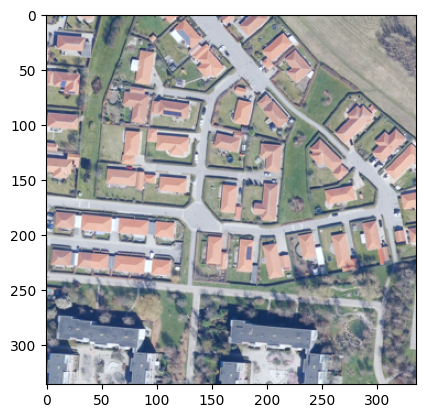

In [10]:
infer_model_(img_torch_2, inference_dict['models'][5],loss_type)

5 < Label > 
5 < Model Prediction > 
tensor([[0.0372, 0.0078, 0.0076, 0.0061, 0.0110, 0.9220, 0.0082]],
       device='cuda:3')


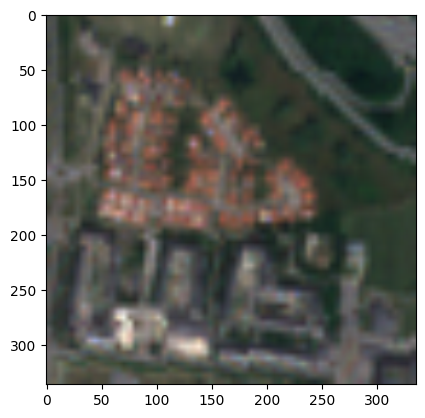

In [11]:
infer_model_(img_torch_3, inference_dict['models'][14],loss_type)

In [12]:
#--- Data 
input_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Map_Your_City/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"
train_df = pd.read_csv(input_path + "train/train-set.csv")
test_df = pd.read_csv(input_path + "test/test-set.csv") 

#--- data split 
names_test = os.listdir(test_path)
names_test = sorted(names_test)

In [13]:
submit_df = pd.DataFrame(
    {"idx":[i for i in range(len(names_test))],
     "names_test":names_test,
     "street_view_exists":[False for i in range(len(names_test))],
     "model_0_street_view_prediction" :[[] for i in range(len(names_test))],
     "model_1_street_view_prediction" :[[] for i in range(len(names_test))],
     "model_2_street_view_prediction" :[[] for i in range(len(names_test))],
     "model_3_street_view_prediction" :[[] for i in range(len(names_test))],
     "model_4_street_view_prediction" :[[] for i in range(len(names_test))],

     "model_5_topview_prediction" :[[] for i in range(len(names_test))],
     "model_6_topview_prediction" :[[] for i in range(len(names_test))],
     "model_7_topview_prediction" :[[] for i in range(len(names_test))],
     "model_8_topview_prediction" :[[] for i in range(len(names_test))],
     "model_9_topview_prediction" :[[] for i in range(len(names_test))],

     "model_10_sentinelview_prediction" :[[] for i in range(len(names_test))],
     "model_11_sentinelview_prediction" :[[] for i in range(len(names_test))],
     "model_12_sentinelview_prediction" :[[] for i in range(len(names_test))],
     "model_13_sentinelview_prediction" :[[] for i in range(len(names_test))],
     "model_14_sentinelview_prediction" :[[] for i in range(len(names_test))]
     })


In [14]:
submit_df.head()

,idx,names_test,street_view_exists,model_0_street_view_prediction,model_1_street_view_prediction,model_2_street_view_prediction,model_3_street_view_prediction,model_4_street_view_prediction,model_5_topview_prediction,model_6_topview_prediction,model_7_topview_prediction,model_8_topview_prediction,model_9_topview_prediction,model_10_sentinelview_prediction,model_11_sentinelview_prediction,model_12_sentinelview_prediction,model_13_sentinelview_prediction,model_14_sentinelview_prediction
0,0,22mhjewvtj,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
1,1,22pujdqtiu,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
2,2,23ykackznc,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
3,3,2435ikdnmf,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
4,4,24akvvheae,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]


In [15]:
for ID in names_test:
    street_file_ = os.path.join( test_path + ID + '/street.jpg')
    if os.path.exists(street_file_):
        submit_df.loc[submit_df['names_test'] == ID, 'street_view_exists'] = True

In [16]:
submit_df.head()

,idx,names_test,street_view_exists,model_0_street_view_prediction,model_1_street_view_prediction,model_2_street_view_prediction,model_3_street_view_prediction,model_4_street_view_prediction,model_5_topview_prediction,model_6_topview_prediction,model_7_topview_prediction,model_8_topview_prediction,model_9_topview_prediction,model_10_sentinelview_prediction,model_11_sentinelview_prediction,model_12_sentinelview_prediction,model_13_sentinelview_prediction,model_14_sentinelview_prediction
0,0,22mhjewvtj,True,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
1,1,22pujdqtiu,True,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
2,2,23ykackznc,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
3,3,2435ikdnmf,True,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
4,4,24akvvheae,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]


In [17]:
street_view_names = submit_df.loc[submit_df['street_view_exists'] == True, 'names_test']
street_view_names = sorted(street_view_names)

In [18]:
len(street_view_names)

2167

In [19]:
inference_dict.keys()

dict_keys(['models', 'folds', 'data', 'cfgs', 'predictions', 'labels'])

# 0.Inference for Streetview 

In [20]:
device = "cuda:3"

for model_idx in range(5):
        
    #--------------------
    if model_idx < 5:
        view_name = "street_view"
    elif 5 <= model_idx < 10:
        view_name = "topview"
    elif 10 <= model_idx:
        view_name = "sentinelview"


    #--------------------
    model = inference_dict['models'][model_idx]
    cfg = inference_dict['cfgs'][model_idx]

    def find_data_config(cfg):
        model = timm.create_model(
        cfg.MODEL,
        pretrained=True,
        num_classes=cfg.CLASSES_NUM )

        #--- data config and transform
        data_config = timm.data.resolve_model_data_config(model)

        return data_config
    #---- 
    data_config = find_data_config(cfg)
    test_set = map_dataset.Map_Dataset_v14(street_view_names,test_path,max_size=data_config['input_size'][1],cfg=cfg,split="test") 
    batch_size = 1
    TestLoader = DataLoader(test_set,batch_size,shuffle=False)

    device = "cuda:3"

    #-- Loader train/valid
    Loader = TestLoader

    predictions_ = []
    model = model.to(device) 
    for batch in tqdm(Loader):
        #print("model idx : ", model_idx)
        if model_idx < 5:
            input_img = batch[0].to(device)
        elif 5 <= model_idx < 10:
            input_img = batch[1].to(device)
        elif 10 <= model_idx:
            input_img = batch[2].to(device)

        batch_preds = model(input_img)
        #-- 
        predictions_.extend(batch_preds.detach().cpu())

    #--- insert prediction into DataFrame 
    cnt = 0
    for name, pred in tqdm(zip(street_view_names,predictions_)):
        #print(name,pred)
        #pred_ = [i.softmax(-1).argmax(-1).numpy() for i in predictions_][cnt]
        pred_ = [i.softmax(-1).numpy() for i in predictions_][cnt]
        #print(pred_)
        #submit_df.loc[submit_df['names_test'] == name, 'street_view_prediction']._append(pd.DataFrame( np.asarray(pred)) )
        
        Obj = submit_df['names_test'] == name
        idx_true = [ (i,v) for (i,v) in Obj.items() if v == True][0][0]
        #submit_df.loc[idx_true, 'street_view_exists'] = pred_
        submit_df.at[idx_true, f'model_{model_idx}_{view_name}_prediction'] = pred_
        cnt +=1

    #--- check
    #cnt == len(street_view_names)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
100%|██████████| 2167/2167 [01:57<00:00, 18.43it/s]
2167it [00:25, 85.79it/s] 
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
100%|██████████| 2167/2167 [01:47<00:00, 20.15it/s]
2167it [00:20, 105.55it/s]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'p

In [21]:
submit_df

,idx,names_test,street_view_exists,model_0_street_view_prediction,model_1_street_view_prediction,model_2_street_view_prediction,model_3_street_view_prediction,model_4_street_view_prediction,model_5_topview_prediction,model_6_topview_prediction,model_7_topview_prediction,model_8_topview_prediction,model_9_topview_prediction,model_10_sentinelview_prediction,model_11_sentinelview_prediction,model_12_sentinelview_prediction,model_13_sentinelview_prediction,model_14_sentinelview_prediction
0,0,22mhjewvtj,True,"[0.044405278, 0.021217475, 0.021739252, 0.6033...","[0.088833675, 0.14552388, 0.13003692, 0.371868...","[0.013751423, 0.02263701, 0.007976813, 0.91288...","[0.047087677, 0.044248585, 0.009550515, 0.2637...","[0.024491567, 0.050962158, 0.04039039, 0.37710...",[],[],[],[],[],[],[],[],[],[]
1,1,22pujdqtiu,True,"[0.023025183, 0.032719634, 0.04194046, 0.01526...","[0.021601703, 0.01283179, 0.007840465, 0.03705...","[0.012477504, 0.008905292, 0.021564735, 0.0088...","[0.043068122, 0.035086315, 0.026937189, 0.0134...","[0.020982912, 0.04486931, 0.13137707, 0.022457...",[],[],[],[],[],[],[],[],[],[]
2,2,23ykackznc,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
3,3,2435ikdnmf,True,"[0.02200964, 0.123928525, 0.729839, 0.0184158,...","[0.028181456, 0.5700479, 0.27250677, 0.0282663...","[0.016933938, 0.042037543, 0.8293347, 0.037083...","[0.03189985, 0.59042853, 0.2455794, 0.04098723...","[0.009458189, 0.7219537, 0.15215857, 0.0235484...",[],[],[],[],[],[],[],[],[],[]
4,4,24akvvheae,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4524,4524,zz33egthkw,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
4525,4525,zzfq447gpt,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
4526,4526,zzijnoebwv,True,"[0.45758402, 0.17755145, 0.021833299, 0.027772...","[0.08424515, 0.2296147, 0.1241127, 0.03096411,...","[0.60411566, 0.11773229, 0.028026184, 0.040949...","[0.9252715, 0.014017587, 0.017580409, 0.011229...","[0.8982936, 0.005767503, 0.008348411, 0.018290...",[],[],[],[],[],[],[],[],[],[]
4527,4527,zzphni4qma,True,"[0.40863284, 0.37830454, 0.05020952, 0.0668403...","[0.84907424, 0.039363723, 0.019763432, 0.01583...","[0.30738652, 0.43974033, 0.051862407, 0.016995...","[0.43896937, 0.3726683, 0.025602017, 0.0212168...","[0.21561095, 0.6674909, 0.017863845, 0.0161702...",[],[],[],[],[],[],[],[],[],[]


In [22]:
device = "cuda:3"

infer_names = [i for i in submit_df['names_test']]
for model_idx in range(5,10):

    #--------------------
    if model_idx < 5:
        view_name = "street_view"
    elif 5 <= model_idx < 10:
        view_name = "topview"
    elif 10 <= model_idx:
        view_name = "sentinelview"


    #--------------------
    model = inference_dict['models'][model_idx]
    cfg = inference_dict['cfgs'][model_idx]

    def find_data_config(cfg):
        model = timm.create_model(
        cfg.MODEL,
        pretrained=True,
        num_classes=cfg.CLASSES_NUM )

        #--- data config and transform
        data_config = timm.data.resolve_model_data_config(model)

        return data_config
    #---- 
    data_config = find_data_config(cfg)


    #---
    test_set = map_dataset.Map_Dataset_v14(infer_names,test_path,max_size=data_config['input_size'][1],cfg=cfg,split="test",test_mode="top_view_only") 
    batch_size = 1
    TestLoader = DataLoader(test_set,batch_size,shuffle=False)

    device = "cuda:3"

    #-- Loader train/valid
    Loader = TestLoader

    predictions_ = []
    model = model.to(device) 
    for batch in tqdm(Loader):
        #print("model idx : ", model_idx)
        if model_idx < 5:
            input_img = batch[0].to(device)
        elif 5 <= model_idx < 10:
            input_img = batch[1].to(device)
        elif 10 <= model_idx:
            input_img = batch[2].to(device)

        batch_preds = model(input_img)
        #-- 
        predictions_.extend(batch_preds.detach().cpu())

    #--- insert prediction into DataFrame 
    cnt = 0
    for name, pred in tqdm(zip(infer_names,predictions_)):
        pred_ = [i.softmax(-1).numpy() for i in predictions_][cnt]

        submit_df.at[cnt, f'model_{model_idx}_{view_name}_prediction'] = pred_
        cnt +=1

    #--- check
    #cnt == len(street_view_names)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
100%|██████████| 4529/4529 [03:17<00:00, 22.96it/s]
4529it [01:41, 44.47it/s]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
100%|██████████| 4529/4529 [03:01<00:00, 24.91it/s]
4529it [02:19, 32.39it/s]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pyt

In [23]:
submit_df

,idx,names_test,street_view_exists,model_0_street_view_prediction,model_1_street_view_prediction,model_2_street_view_prediction,model_3_street_view_prediction,model_4_street_view_prediction,model_5_topview_prediction,model_6_topview_prediction,model_7_topview_prediction,model_8_topview_prediction,model_9_topview_prediction,model_10_sentinelview_prediction,model_11_sentinelview_prediction,model_12_sentinelview_prediction,model_13_sentinelview_prediction,model_14_sentinelview_prediction
0,0,22mhjewvtj,True,"[0.044405278, 0.021217475, 0.021739252, 0.6033...","[0.088833675, 0.14552388, 0.13003692, 0.371868...","[0.013751423, 0.02263701, 0.007976813, 0.91288...","[0.047087677, 0.044248585, 0.009550515, 0.2637...","[0.024491567, 0.050962158, 0.04039039, 0.37710...","[0.027653798, 0.053688485, 0.14861456, 0.51624...","[0.015122413, 0.014152057, 0.014236362, 0.0281...","[0.019977963, 0.0024163523, 0.014329356, 0.021...","[0.009827962, 0.007895525, 0.006949314, 0.0197...","[0.046048183, 0.04413424, 0.07495206, 0.542328...",[],[],[],[],[]
1,1,22pujdqtiu,True,"[0.023025183, 0.032719634, 0.04194046, 0.01526...","[0.021601703, 0.01283179, 0.007840465, 0.03705...","[0.012477504, 0.008905292, 0.021564735, 0.0088...","[0.043068122, 0.035086315, 0.026937189, 0.0134...","[0.020982912, 0.04486931, 0.13137707, 0.022457...","[0.0060903532, 0.013055253, 0.005686972, 0.003...","[0.0034320205, 0.04773989, 0.018661987, 0.0081...","[0.0027678264, 0.016000316, 0.016627459, 0.008...","[0.0040549347, 0.08192595, 0.03048218, 0.00990...","[0.023507144, 0.023803147, 0.023337403, 0.0210...",[],[],[],[],[]
2,2,23ykackznc,False,[],[],[],[],[],"[0.027439877, 0.13907313, 0.28004685, 0.302630...","[0.081120215, 0.11246052, 0.16362889, 0.205068...","[0.30793667, 0.05648569, 0.23932743, 0.1400310...","[0.017291844, 0.346401, 0.13618119, 0.16346379...","[0.21939339, 0.15418863, 0.14193036, 0.1906666...",[],[],[],[],[]
3,3,2435ikdnmf,True,"[0.02200964, 0.123928525, 0.729839, 0.0184158,...","[0.028181456, 0.5700479, 0.27250677, 0.0282663...","[0.016933938, 0.042037543, 0.8293347, 0.037083...","[0.03189985, 0.59042853, 0.2455794, 0.04098723...","[0.009458189, 0.7219537, 0.15215857, 0.0235484...","[0.07017467, 0.7840641, 0.053533144, 0.0275773...","[0.79596424, 0.12053491, 0.014715568, 0.036201...","[0.8695771, 0.09010721, 0.0035316988, 0.005209...","[0.7518747, 0.17442681, 0.009344586, 0.0246212...","[0.46550986, 0.297821, 0.14731447, 0.030383503...",[],[],[],[],[]
4,4,24akvvheae,False,[],[],[],[],[],"[0.35456976, 0.09477183, 0.08120549, 0.1463943...","[0.53380084, 0.036517125, 0.18101107, 0.133966...","[0.1958802, 0.013647528, 0.5126641, 0.16534685...","[0.4207579, 0.18770057, 0.06962503, 0.1110991,...","[0.44235665, 0.16214472, 0.17223229, 0.1006965...",[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4524,4524,zz33egthkw,False,[],[],[],[],[],"[0.0020665757, 0.0022914056, 0.042313542, 0.92...","[0.0087843435, 0.03640193, 0.56422025, 0.21774...","[0.026019406, 0.03393351, 0.3957031, 0.1298547...","[0.025424318, 0.10768014, 0.46926928, 0.207422...","[0.123435766, 0.06616394, 0.119787544, 0.46861...",[],[],[],[],[]
4525,4525,zzfq447gpt,False,[],[],[],[],[],"[0.53752863, 0.042800196, 0.04436079, 0.003899...","[0.42415833, 0.0067410185, 0.120945774, 0.0103...","[0.88907844, 0.025028689, 0.012416554, 0.00173...","[0.7617425, 0.004296639, 0.0041012857, 0.00318...","[0.5859463, 0.06841294, 0.07203415, 0.01862325...",[],[],[],[],[]
4526,4526,zzijnoebwv,True,"[0.45758402, 0.17755145, 0.021833299, 0.027772...","[0.08424515, 0.2296147, 0.1241127, 0.03096411,...","[0.60411566, 0.11773229, 0.028026184, 0.040949...","[0.9252715, 0.014017587, 0.017580409, 0.011229...","[0.8982936, 0.005767503, 0.008348411, 0.018290...","[0.22518568, 0.0066933488, 0.019902654, 0.0024...","[0.63735753, 0.011695889, 0.033634894, 0.00135...","[0.7870912, 0.013072341, 0.020996489, 0.004701...","[0.61401206, 0.0100985365, 0.01495334, 0.00329...","[0.7148843, 0.0805

In [24]:
submit_df.to_csv("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/submissions/ensemble_v5.csv",index=False)

In [25]:
device = "cuda:3"

infer_names = [i for i in submit_df['names_test']]
for model_idx in range(10,15):

    #--------------------
    if model_idx < 5:
        view_name = "street_view"
    elif 5 <= model_idx < 10:
        view_name = "topview"
    elif 10 <= model_idx:
        view_name = "sentinelview"


    #--------------------
    model = inference_dict['models'][model_idx]
    cfg = inference_dict['cfgs'][model_idx]

    def find_data_config(cfg):
        model = timm.create_model(
        cfg.MODEL,
        pretrained=True,
        num_classes=cfg.CLASSES_NUM )

        #--- data config and transform
        data_config = timm.data.resolve_model_data_config(model)

        return data_config
    #---- 
    data_config = find_data_config(cfg)


    #---
    test_set = map_dataset.Map_Dataset_v14(infer_names,test_path,max_size=data_config['input_size'][1],cfg=cfg,split="test",test_mode="top_view_only") 
    batch_size = 1
    TestLoader = DataLoader(test_set,batch_size,shuffle=False)

    device = "cuda:3"

    #-- Loader train/valid
    Loader = TestLoader

    predictions_ = []
    model = model.to(device) 
    for batch in tqdm(Loader):
        #print("model idx : ", model_idx)
        if model_idx < 5:
            input_img = batch[0].to(device)
        elif 5 <= model_idx < 10:
            input_img = batch[1].to(device)
        elif 10 <= model_idx:
            input_img = batch[2].to(device)

        batch_preds = model(input_img)
        #-- 
        predictions_.extend(batch_preds.detach().cpu())

    #--- insert prediction into DataFrame 
    cnt = 0
    for name, pred in tqdm(zip(infer_names,predictions_)):
        pred_ = [i.softmax(-1).numpy() for i in predictions_][cnt]

        submit_df.at[cnt, f'model_{model_idx}_{view_name}_prediction'] = pred_
        cnt +=1

    #--- check
    #cnt == len(street_view_names)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
  7%|▋         | 315/4529 [00:12<02:47, 25.13it/s]

100%|██████████| 4529/4529 [03:01<00:00, 24.93it/s]
4529it [01:29, 50.64it/s]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
100%|██████████| 4529/4529 [03:01<00:00, 24.90it/s]
4529it [02:17, 32.85it/s]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva_large_patch14_336.in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
100%|██████████| 4529/4529 [03:00<00:00, 25.11it/s]
4529it [01:24, 53.53it/s]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva_large_patch14_336.in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/

In [26]:
submit_df.to_csv("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/submissions/ensemble_v7.csv",index=False)

In [27]:
submit_df

,idx,names_test,street_view_exists,model_0_street_view_prediction,model_1_street_view_prediction,model_2_street_view_prediction,model_3_street_view_prediction,model_4_street_view_prediction,model_5_topview_prediction,model_6_topview_prediction,model_7_topview_prediction,model_8_topview_prediction,model_9_topview_prediction,model_10_sentinelview_prediction,model_11_sentinelview_prediction,model_12_sentinelview_prediction,model_13_sentinelview_prediction,model_14_sentinelview_prediction
0,0,22mhjewvtj,True,"[0.044405278, 0.021217475, 0.021739252, 0.6033...","[0.088833675, 0.14552388, 0.13003692, 0.371868...","[0.013751423, 0.02263701, 0.007976813, 0.91288...","[0.047087677, 0.044248585, 0.009550515, 0.2637...","[0.024491567, 0.050962158, 0.04039039, 0.37710...","[0.027653798, 0.053688485, 0.14861456, 0.51624...","[0.015122413, 0.014152057, 0.014236362, 0.0281...","[0.019977963, 0.0024163523, 0.014329356, 0.021...","[0.009827962, 0.007895525, 0.006949314, 0.0197...","[0.046048183, 0.04413424, 0.07495206, 0.542328...","[0.053553883, 0.05659965, 0.049879204, 0.29398...","[0.07116288, 0.01779329, 0.0026666236, 0.01243...","[0.08407853, 0.06608973, 0.040375397, 0.296487...","[0.07689912, 0.04107524, 0.0045472733, 0.48828...","[0.13952099, 0.05692961, 0.0061176983, 0.56965..."
1,1,22pujdqtiu,True,"[0.023025183, 0.032719634, 0.04194046, 0.01526...","[0.021601703, 0.01283179, 0.007840465, 0.03705...","[0.012477504, 0.008905292, 0.021564735, 0.0088...","[0.043068122, 0.035086315, 0.026937189, 0.0134...","[0.020982912, 0.04486931, 0.13137707, 0.022457...","[0.0060903532, 0.013055253, 0.005686972, 0.003...","[0.0034320205, 0.04773989, 0.018661987, 0.0081...","[0.0027678264, 0.016000316, 0.016627459, 0.008...","[0.0040549347, 0.08192595, 0.03048218, 0.00990...","[0.023507144, 0.023803147, 0.023337403, 0.0210...","[0.03241316, 0.6063966, 0.061036292, 0.0011416...","[0.05256351, 0.3805208, 0.3476568, 0.009652453...","[0.12448965, 0.36065722, 0.031598132, 0.015085...","[0.026837468, 0.46396312, 0.07413713, 0.008485...","[0.5010854, 0.044751618, 0.08164548, 0.0067901..."
2,2,23ykackznc,False,[],[],[],[],[],"[0.027439877, 0.13907313, 0.28004685, 0.302630...","[0.081120215, 0.11246052, 0.16362889, 0.205068...","[0.30793667, 0.05648569, 0.23932743, 0.1400310...","[0.017291844, 0.346401, 0.13618119, 0.16346379...","[0.21939339, 0.15418863, 0.14193036, 0.1906666...","[0.55419654, 0.27147478, 0.064099014, 0.026325...","[0.16461281, 0.30366313, 0.26158512, 0.1123577...","[0.45575294, 0.29254204, 0.11538768, 0.0618781...","[0.30107123, 0.27331463, 0.32189646, 0.0373371...","[0.38504225, 0.39407313, 0.038145423, 0.129130..."
3,3,2435ikdnmf,True,"[0.02200964, 0.123928525, 0.729839, 0.0184158,...","[0.028181456, 0.5700479, 0.27250677, 0.0282663...","[0.016933938, 0.042037543, 0.8293347, 0.037083...","[0.03189985, 0.59042853, 0.2455794, 0.04098723...","[0.009458189, 0.7219537, 0.15215857, 0.0235484...","[0.07017467, 0.7840641, 0.053533144, 0.0275773...","[0.79596424, 0.12053491, 0.014715568, 0.036201...","[0.8695771, 0.09010721, 0.0035316988, 0.005209...","[0.7518747, 0.17442681, 0.009344586, 0.0246212...","[0.46550986, 0.297821, 0.14731447, 0.030383503...","[0.04513915, 0.28457752, 0.5955844, 0.01309271...","[0.42770678, 0.40522152, 0.10663807, 0.0160079...","[0.08431373, 0.38896748, 0.4603621, 0.01657893...","[0.2557502, 0.6970933, 0.023488116, 0.00374269...","[0.09663316, 0.7321474, 0.065369785, 0.0524764..."
4,4,24akvvheae,False,[],[],[],[],[],"[0.35456976, 0.09477183, 0.08120549, 0.1463943...","[0.53380084, 0.036517125, 0.18101107, 0.133966...","[0.1958802, 0.013647528, 0.5126641, 0.16534685...","[0.4207579, 0.18770057, 0.06962503, 0.1110991,...","[0.44235665, 0.16214472, 0.17223229, 0.1006965...","[0.8775822, 0.03103371, 0.0117744375, 0.027732...","[0.8637154, 0.028426098, 0.019511824, 0.020897...","[0.61021596, 0.08896507, 0.06978733, 0.0795999...","[0.758999, 0.054195613, 0.09683099, 0.03630317...","[0.75575763, 0.021175945, 0.042809427, 0.04361...

In [28]:
tmp_ = []
for i,row in submit_df.iterrows():
    #print(row['street_view_exists'])
    
    if row['street_view_exists'] == True:
        #print(row.values[3:])
        result_ = sum( row.values[3:] ) / len(row.values[3:]) 
        tmp_.append(result_)
    else:
        result_ = sum( row.values[8:] ) / len(row.values[8:]) 
        tmp_.append(result_)


In [29]:
result_.__len__()

7

In [30]:
tmp_.__len__()

4529

In [31]:
sub_file = pd.read_csv("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/submissions/ensemble_v3.csv") 

In [32]:
sub_file

,country_id,pid,city_id,predicted_label
0,QCD,22mhjewvtj,YPGHW,4
1,QCD,22pujdqtiu,YPGHW,5
2,FMW,23ykackznc,7PNBD,3
3,QCD,2435ikdnmf,YPGHW,1
4,FMW,24akvvheae,7PNBD,0
...,...,...,...,...
4524,FMW,zz33egthkw,7PNBD,0
4525,PNN,zzfq447gpt,B2MVH,0
4526,QCD,zzijnoebwv,YPGHW,0
4527,QCD,zzphni4qma,YPGHW,1


In [33]:
sub_file['predicted_label'] = [ np.argmax(i) for i in tmp_]

In [34]:
sub_file

,country_id,pid,city_id,predicted_label
0,QCD,22mhjewvtj,YPGHW,4
1,QCD,22pujdqtiu,YPGHW,5
2,FMW,23ykackznc,7PNBD,0
3,QCD,2435ikdnmf,YPGHW,1
4,FMW,24akvvheae,7PNBD,0
...,...,...,...,...
4524,FMW,zz33egthkw,7PNBD,3
4525,PNN,zzfq447gpt,B2MVH,0
4526,QCD,zzijnoebwv,YPGHW,0
4527,QCD,zzphni4qma,YPGHW,1


In [35]:
sub_file.to_csv("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/submissions/ensemble_15_models_v2.csv",index=False)